# **Optimal Policy Learning**

**Authors:** [Anthony Strittmatter](http://www.anthonystrittmatter.com)

The charity Freedom from Hunger implemented a randomised trial to improve its direct marketing campaign. The solicitations letters vary by whether they include a discussion of their program's impact as measured by scientific research. We investigate how donors respond to information about a charity’s effectiveness. The base script, used for both treatment and control, included a standard qualitative story about an individual beneficiary. The allocation of the ''scientific mailer'' is randomised.


Reference: [Karlan and Wood (2017)](https://www.sciencedirect.com/science/article/pii/S2214804316300490)

Variable list:


+ **char_giving**: Donation in response to mail
+ **treat**: Mailer includes a discussion about the program impact as measured by scientific research


+ **amount_pre**: Total amount given before mailer
+ **amount_lastpre**: Amount of last gift before mailer
+ **amount_maxpre**: Largest gift before mailer
+ **H_number_yearbefore**: \# of donations given in year prior to experiment
+ **H_ngifts**: Number of donations over donor's giving history before mailer
+ **H_littleask**: Received mailer with small ask string-small donor in past
+ **H_bigask**: Received mailer with big ask string-big donor in past
+ **H_nyears**: Number of years donor is in database before specified mailer
+ **H_frequency**: Number of gifts per year (that donor was in donor database before specified mail)
+ **H_medinc**: Median zip code income
+ **H_medinc_mdum**: Dummy to reflect replacement to 0 when missing
+ **H_Avg_years_ed**: Average years of education in census tract
+ **H_Avg_years_ed_mdum**: Dummy to reflect replacement to 0 when missing

We want is to find a targeting rule for the allocation of the ''scientific letter'' that increases donations.

## Load Packages

In [1]:
########################  Load Packages  ########################

# List of required packages
pkgs <- c('fBasics', 'corrplot', 'rpart', 'rpart.plot', 'tidyverse', 'grf', 'caret')

# Load packages
for(pkg in pkgs){
    library(pkg, character.only = TRUE)
}
options(warn=-1)     # supress warnings

print('All packages successfully installed and loaded.')

###################################################################

Loading required package: timeDate

Loading required package: timeSeries

corrplot 0.84 loaded

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks timeSeries::filter(), stats::filter()
✖ dplyr::lag()    masks timeSeries::lag(), stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




[1] "All packages successfully installed and loaded."


## Load Data

In [2]:
########################  Load Data Frame  ########################

# Load data frame
df <- read.csv("fundraising.csv",header=TRUE, sep=",")

# Outcome Variable
outcome <- c("char_giving")

# Treatment Variables
treatment <- c("treat")

# Covariates/Features
covariates <- c("amount_pre", "amount_lastpre", "amount_maxpre", "H_number_yearbefore", "H_ngifts",
                "H_littleask", "H_bigask", "H_nyears", "H_frequency", "H_medinc", "H_medinc_mdum",
                "H_Avg_years_ed", "H_Avg_years_ed_mdum")

all_variables <- c(outcome, treatment, covariates)

print('Data frame successfully loaded and sample selected.')

######################################################################

[1] "Data frame successfully loaded and sample selected."


## Desriptive Statistics

#### Mean and Standard Deviations

In [3]:
########################  Table with Descriptive Statistics  ########################

desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
  select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=2))

#####################################################################################

                        Mean    Stdev Minimum   Maximum  nobs
char_giving            14.94   267.05    0.00  30000.00 23122
treat                   0.50     0.50    0.00      1.00 23122
amount_pre            320.90  1137.65    1.00  62849.99 23122
amount_lastpre         50.79   266.59    1.00  25707.36 23122
amount_maxpre          71.27   353.36    1.00  25707.36 23122
H_number_yearbefore     0.74     1.16    0.00     21.00 23122
H_ngifts                6.97    11.58    1.00    261.00 23122
H_littleask             0.88     0.33    0.00      1.00 23122
H_bigask                0.12     0.33    0.00      1.00 23122
H_nyears                7.35     7.08    1.00     54.00 23122
H_frequency             0.86     0.83    0.08     10.50 23122
H_medinc            52056.29 24061.48    0.00 200001.00 23122
H_medinc_mdum           0.03     0.18    0.00      1.00 23122
H_Avg_years_ed         14.00     2.98    0.00     21.05 23122
H_Avg_years_ed_mdum     0.03     0.18    0.00      1.00 23122


The outcome variable *char_giving* is highly right-skewed. 

### Correlations

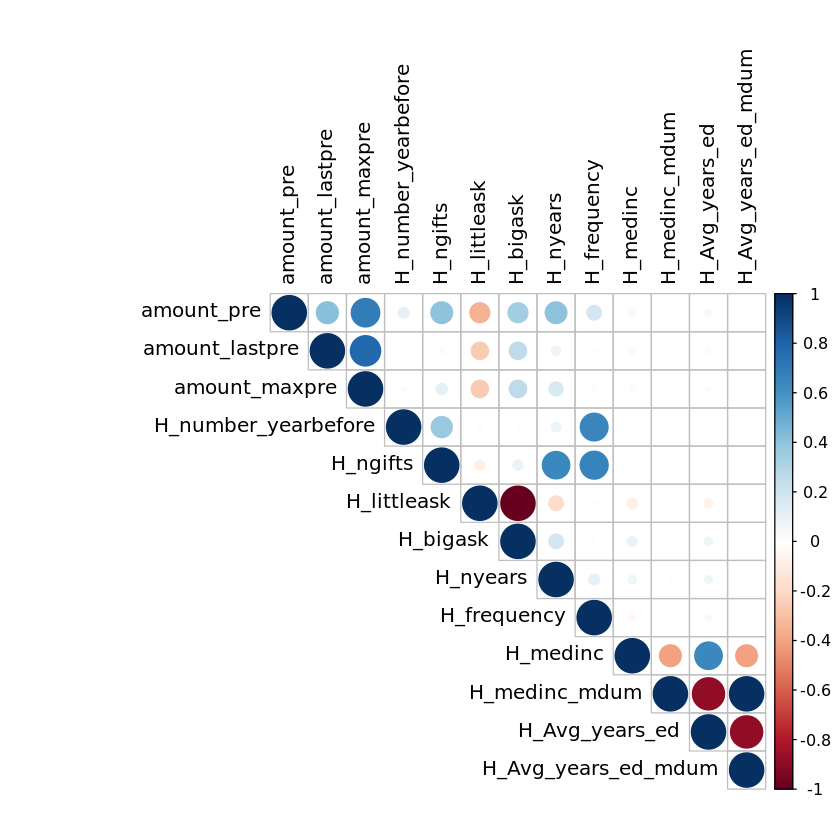

In [4]:
########################  Correlation Matrix  ########################

corr = cor(df[,-c(1:2)])
corrplot(corr, type = "upper", tl.col = "black")

######################################################################

The sum of past givings (*amount_pre*) is highly correleted with several other covariates.

# Prepare Data

In [5]:
########################  Partition the Samples  ########################
set.seed(100239) # set starting value for random number generator

# Partition Hold-Out-Sample
df_part <- modelr::resample_partition(df, c(obs = 0.8, hold_out = 0.2))
df_obs <- as.data.frame(df_part$obs) # Training and estimation sample
df_hold_out <- as.data.frame(df_part$hold_out) # Hold-out-sample

# Partition Samples for Cross-Fitting
df_part <- modelr::resample_partition(df_obs, c(obs_A = 0.5, obs_B = 0.5))
df_obs_A <- as.data.frame(df_part$obs_A) # Sample A
df_obs_B <- as.data.frame(df_part$obs_B) # Sample B

print('Samples are partitioned.')

########################  Generate Variables  ########################

# Outcome
giving_hold_out <- as.matrix(df_hold_out[,1])
giving_obs <- as.matrix(df_obs[,1])
giving_obs_A <- as.matrix(df_obs_A[,1])
giving_obs_B <- as.matrix(df_obs_B[,1])

# Treatment
treat_hold_out <- as.matrix(df_hold_out[,2])
treat_obs <- as.matrix(df_obs[,2])
treat_obs_A <- as.matrix(df_obs_A[,2])
treat_obs_B <- as.matrix(df_obs_B[,2])

# Covariates
covariates_hold_out <- as.matrix(df_hold_out[,c(3:ncol(df_hold_out))])
covariates_obs <- as.matrix(df_obs[,c(3:ncol(df_obs))])
covariates_obs_A <- as.matrix(df_obs_A[,c(3:ncol(df_obs_A))])
covariates_obs_B <- as.matrix(df_obs_B[,c(3:ncol(df_obs_B))])

########################  Standardise Covariates  ########################

preProcValues <- preProcess(covariates_obs, method = c("center", "scale"))
covariates_hold_out <- predict(preProcValues, covariates_hold_out) 
covariates_obs <- predict(preProcValues, covariates_obs) 
covariates_obs_A <- predict(preProcValues, covariates_obs_A) 
covariates_obs_B <- predict(preProcValues, covariates_obs_B) 

df_obs <- as.data.frame(cbind(giving_obs,treat_obs,covariates_obs))
df_obs_A <- as.data.frame(cbind(giving_obs_A,treat_obs_A,covariates_obs_A))
df_obs_B <- as.data.frame(cbind(giving_obs_B,treat_obs_B,covariates_obs_B))
covariates_hold_out <- as.data.frame(covariates_hold_out)

print('Covariates are standardised.')
print('The data is now ready for your analysis!')

###########################################################################

[1] "Samples are partitioned."
[1] "Covariates are standardised."
[1] "The data is now ready for your analysis!"


# Nuisance Parameters

We use generalised random forests (*grf-package*) to predict the outcome ([Athey, Tibshirani, Wager, 2018](https://arxiv.org/abs/1610.01271)).

## Potential Outcomes

In [6]:
########################  Potential Outcomes  ######################## 
set.seed(100244)

# Tuning parameters
min_tree = 20
# Number of trees is set to a very low value in order to increase the computational speed in this tutorial
num_trees = 100 # Use at least 1,000 trees
cov_frac = 1/3
sample_part= 0.5

# Build generalised random forest

# Use Sample A to predict Sample B
# Potential outcome under treatment
f_y1_A <- regression_forest(covariates_obs_A[treat_obs_A == 1,], giving_obs_A[treat_obs_A == 1, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y1hat_B <- as.matrix(predict(f_y1_A, covariates_obs_B)$predictions)
y1hat_B_hold_out <- as.matrix(predict(f_y1_A, covariates_hold_out)$predictions)

# Potential outcome under non-treatment
f_y0_A <- regression_forest(covariates_obs_A[treat_obs_A == 0,], giving_obs_A[treat_obs_A == 0, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y0hat_B <- as.matrix(predict(f_y0_A, covariates_obs_B)$predictions)
y0hat_B_hold_out <- as.matrix(predict(f_y0_A, covariates_hold_out)$predictions)

###########################################################################

# Use Sample B to predict Sample A
# Potential outcome under treatment
f_y1_B <- regression_forest(covariates_obs_B[treat_obs_B == 1,], giving_obs_B[treat_obs_B == 1, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y1hat_A <- as.matrix(predict(f_y1_B, covariates_obs_A)$predictions)
y1hat_A_hold_out <- as.matrix(predict(f_y1_B, covariates_hold_out)$predictions)

# Potential outcome under non-treatment
f_y0_B <- regression_forest(covariates_obs_B[treat_obs_B == 0,], giving_obs_B[treat_obs_B == 0, ],
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
y0hat_A <- as.matrix(predict(f_y0_B, covariates_obs_A)$predictions)
y0hat_A_hold_out <- as.matrix(predict(f_y0_B, covariates_hold_out)$predictions)

###########################################################################

# Merge the fitted values from samples A and B
y1hat <- rbind(y1hat_A,y1hat_B)
y0hat <- rbind(y0hat_A,y0hat_B)

y1hat_hold_out <- (y1hat_A_hold_out+y1hat_B_hold_out)/2
y0hat_hold_out <- (y0hat_A_hold_out+y0hat_B_hold_out)/2

print("Potential outcomes are estimated")

###########################################################################

[1] "Potential outcomes are estimated"


## Propensity Score

In [7]:
########################  Propensity Score  ######################## 
set.seed(100243)

# Tuning parameters
min_tree = 20
num_trees = 100 # Use at least 1,000 trees
cov_frac = 1/3
sample_part= 0.5

# Use Sample A to predict Sample B
f_p_A <- regression_forest(covariates_obs_A, treat_obs_A,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
pscore_B <- as.matrix(predict(f_p_A, covariates_obs_B)$predictions)
pscore_B_hold_out <- as.matrix(predict(f_p_A, covariates_hold_out)$predictions)

# Use Sample B to predict Sample A
f_p_B <- regression_forest(covariates_obs_B, treat_obs_B,
                  sample.fraction = sample_part, mtry = floor(cov_frac*ncol(covariates_obs)), 
                  num.trees = num_trees, min.node.size = min_tree,
                  honesty = TRUE, honesty.fraction = 0.5)
pscore_A <- as.matrix(predict(f_p_B, covariates_obs_A)$predictions)
pscore_A_hold_out <- as.matrix(predict(f_p_B, covariates_hold_out)$predictions)

pscore <- rbind(pscore_A,pscore_B)
pscore_hold_out <- (pscore_A_hold_out+pscore_B_hold_out)/2

print("Propensity scores are estimated")

###########################################################################

[1] "Propensity scores are estimated"


# Average Effects

We use the double machine learning approach to estimate ATEs.

In [8]:
########################  Average Treatment Effects (ATE)  ########################

# Merge samples A and B
giving_obs <- rbind(giving_obs_A,giving_obs_B)
treat_obs <- rbind(treat_obs_A,treat_obs_B)

# Generate Modified Outcome
Y_star = invisible(y1hat - y0hat + treat_obs*(giving_obs - y1hat)/pscore 
            - (1-treat_obs)*(giving_obs - y0hat)/(1-pscore))

# Average Treatment Effect (ATE)
ATE <- round(mean(Y_star), digits=1)
print(paste0("Average Treatment Effect (ATE): ", ATE))

# Standard error
SD_ATE <- round(sqrt(var(Y_star)/length(Y_star)),digits=1)
print(paste0("Standard Error for ATE: ", SD_ATE))

####################################################################################

[1] "Average Treatment Effect (ATE): 4.3"
[1] "Standard Error for ATE: 4.2"


# Optimal Policy Learning Using Shallow Trees

We estimate individualised treatment rules (ITR) using the approach proposed in [Athey and Wager (2021)](https://www.econometricsociety.org/publications/econometrica/2021/01/01/policy-learning-observational-data).

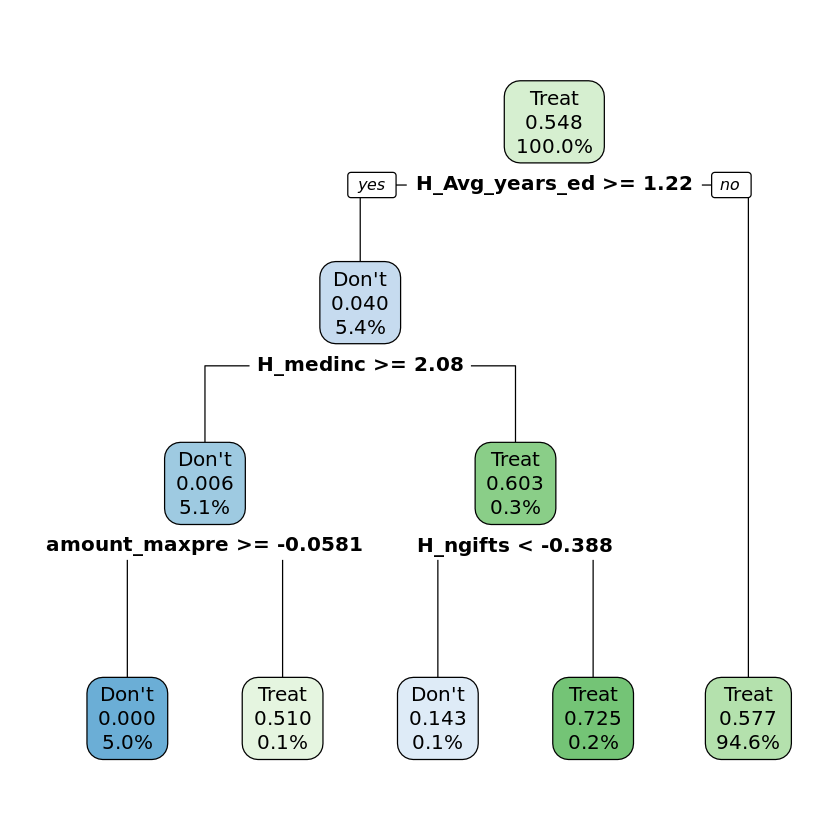

In [9]:
########################  Individualised Treatment Rules  ########################                         

set.seed(1234567)

# Define transformed Variables
sign = sign(Y_star)
lambda = abs(Y_star)
Z <- factor(sign, labels = c("Don't", "Treat"))
df_obs <- rbind(df_obs_A,df_obs_B)

# Genrate linear fromular for tree
sumx <- paste(covariates, collapse = " + ")  
linear <- paste("Z",paste(sumx, sep=" + "), sep=" ~ ")
linear <- as.formula(linear)

########################  Build a Shallow Tree  ########################                         

# Tree 
tree_1 <- rpart(formula = linear, # Predict sign of treatment
                data = df_obs,
                weights = lambda,  # Larger absolute effect -> Higher weight
                method = "class",
                control = rpart.control(cp = 2.00e-10,maxdepth = 3, minbucket=10))

# Plot MSE in CV-Sample
rpart.plot(tree_1,digits=3)

# Predict policy rule to hold-out-sample
pi_tree1_hold_out = as.matrix(predict(tree_1, newdata=covariates_hold_out))

####################################################################################

##  Build Deeper Trees

[1] "Optimal number of splits: 213"


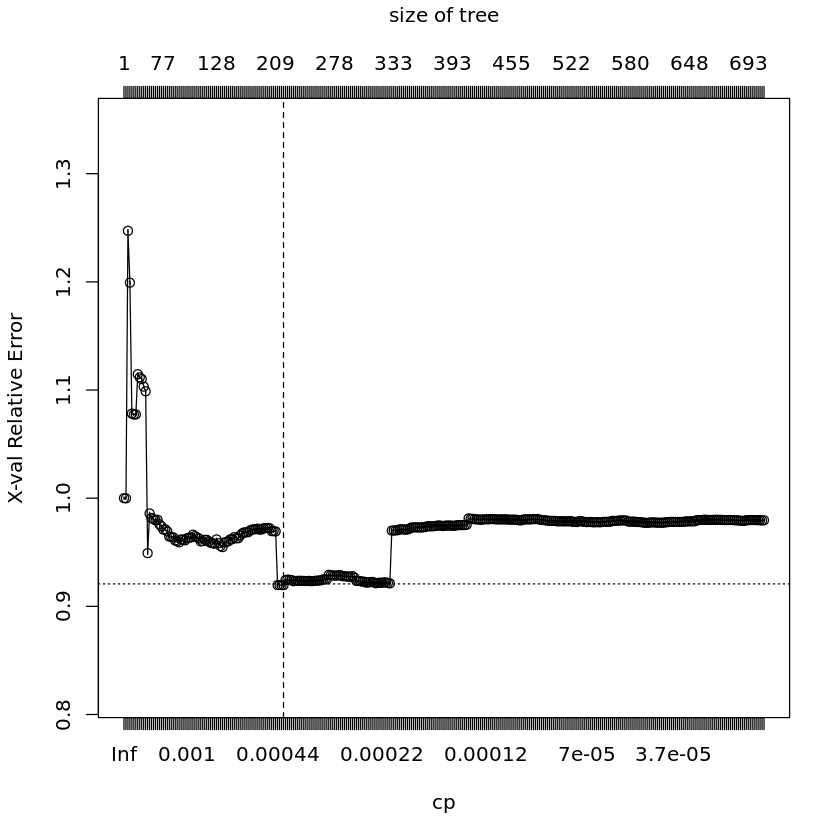

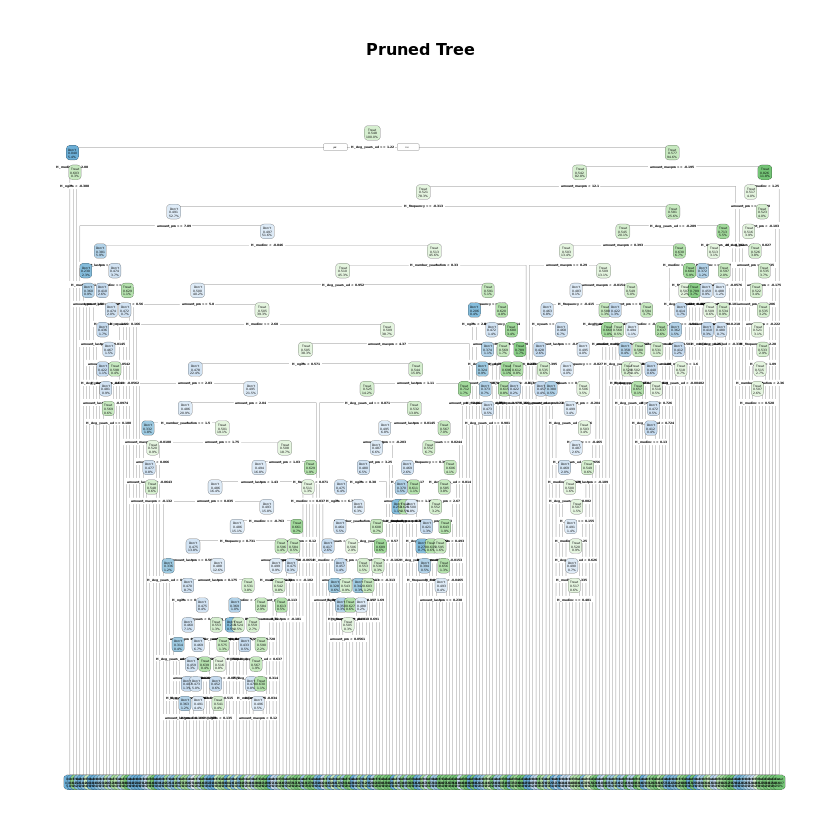

In [12]:
#############################  Build Trees Deeper Tree  #################################                         

set.seed(1234567)

# Tree 
tree_2 <- rpart(formula = linear, # Predict sign of treatment
                data = df_obs,
                weights = lambda,  # Larger absolute effect --> Higher weight
                method = "class",
                control = rpart.control(cp = 2.00e-10, minbucket=10))

# Find optimal tree sizes
op.index_2 <- which.min(tree_2$cptable[, "xerror"])
print(paste0("Optimal number of splits: ", tree_2$cptable[op.index_2, "nsplit"]))

# Plot CV-Error 
plotcp(tree_2, minline = TRUE)
abline(v = op.index_2, lty = "dashed")

########################  Select the Tree that Minimises CV-MSE  ######################## 

# Get cp-value that corresponds to optimal tree sizes
cp.vals_2 <- tree_2$cptable[op.index_2, "CP"]

# Prune the trees
prune_tree_2 <- prune(tree_2, cp = cp.vals_2)

# Plot pruned tree 
rpart.plot(prune_tree_2,digits=3, main = "Pruned Tree")

# Predict policy rule to hold-out-sample
pi_tree2_hold_out = as.matrix(predict(prune_tree_2, newdata=covariates_hold_out))

#########################################################################################

# Out-of-Sample Comparison

Now we go to the hold-out sample to assess the performance of the individualised treatment rules.

In [11]:
########################  Share of Treated  ######################## 

# Rule based on shallow tree (ITR1)
rule_tree_1 <- as.numeric(pi_tree1_hold_out[,1]> .5)
# Rule based on deeper tree (ITR2)
rule_tree_2 <- as.numeric(pi_tree2_hold_out[,1] > .5)
                  
print('Descriptives of Policy Rules')
desc <- fBasics::basicStats(cbind(rule_tree_1,rule_tree_2)) %>% t() %>% as.data.frame() %>% 
  select(Mean, nobs)
print(round(desc, digits=5))

print('Correlation between the Policy Rules')
corr = cor(cbind(rule_tree_1,rule_tree_2))
print(corr)

#####################################################################

[1] "Descriptives of Policy Rules"
               Mean nobs
rule_tree_1 0.00195 4625
rule_tree_2 0.52022 4625
[1] "Correlation between the Policy Rules"
            rule_tree_1 rule_tree_2
rule_tree_1  1.00000000  0.04240521
rule_tree_2  0.04240521  1.00000000


## Average Givings Under Policy Rule

In [12]:
########################  Average Giving Under Policy Rule  ######################## 

# Generate Modified Outcome
y_1_hold_out = invisible(y1hat_hold_out + treat_hold_out*(giving_hold_out - y1hat_hold_out)/pscore_hold_out)
y_0_hold_out = invisible(y0hat_hold_out + (1-treat_hold_out)*(giving_hold_out - y0hat_hold_out)/(1-pscore_hold_out))

# Calulate expected average giving under the different policy rules 
O_tree_1 <- round(mean(rule_tree_1*y_1_hold_out  + (1-rule_tree_1)*y_0_hold_out), digits = 2)
O_tree_2 <- round(mean(rule_tree_2*y_1_hold_out  + (1-rule_tree_2)*y_0_hold_out), digits = 2)

print('Average Givings Under')
print(paste0("Shallow Tree: ",O_tree_1))
print(paste0("Pruned Tree: ",O_tree_2))

#####################################################################################

[1] "Average Givings Under"
[1] "Shallow Tree: 15.68"
[1] "Pruned Tree: 16.18"


## Policy Value Compared to Everybody is Treated

In [13]:
########################  Policy Value Compared to Everybody is Treated  ######################## 

#Modified Outcome
Y_star_hold_out = y_1_hold_out - y_0_hold_out

# Estimate Policy Value
tree_all <- round(mean((rule_tree_2-1)*Y_star_hold_out), digits = 2)
se_tree_all <- round(sqrt(var((rule_tree_2-1)*Y_star_hold_out)/length(Y_star_hold_out)), digits = 2)

print('Total Policy Value Compared to Everybody is Treated')
print(paste0("Average Gain of Pruned Tree: ", tree_all))
print(paste0("Standard Error: ", se_tree_all))

#round(mean(giving_hold_out[treat_hold_out==1,]), digits = 2)
#round(mean((rule_tree_2-1)*Y_star_hold_out)/mean(giving_hold_out[treat_hold_out==1,]), digits = 2)

################################################################################################

[1] "Total Policy Value Compared to Everybody is Treated"
[1] "Average Gain of Pruned Tree: 0.82"
[1] "Standard Error: 4.3"


## Policy Value Compared to Nobody is Treated

In [14]:
########################  Policy Value Compared to Nobody is Treated  ######################## 

# Estimate Policy Value
tree_no <- round(mean(rule_tree_2*Y_star_hold_out), digits = 2)
se_tree_no <- round(sqrt(var(rule_tree_2*Y_star_hold_out)/length(Y_star_hold_out)), digits = 2)

print('Total Policy Value Compared to Nobody is Treated')
print(paste0("Average Gain of Pruned Tree: ", tree_no))
print(paste0("Standard Error: ", se_tree_no))

#round(mean(giving_hold_out[treat_hold_out==0,]), digits = 2)
#round(mean(rule_tree_2*Y_star_hold_out)/mean(giving_hold_out[treat_hold_out==0,]), digits = 2)

################################################################################################

[1] "Total Policy Value Compared to Nobody is Treated"
[1] "Average Gain of Pruned Tree: 0.23"
[1] "Standard Error: 1.35"


## Policy Value Compared to Random Assignment

In [15]:
########################  Policy Value Compared to Random Assignment  ######################## 

# Estimate Policy Value
R1_tree_2 <- round(1/2*mean((2*rule_tree_2-1)*Y_star_hold_out), digits = 2)
se_tree_2 <- round(sqrt(1/4*var((2*rule_tree_2-1)*Y_star_hold_out)/length(Y_star_hold_out)), digits = 2)


print('Total Policy Value Compared to Random Assignment')
print(paste0("Average Gain of Pruned Tree: ", R1_tree_2))
print(paste0("Standard Error: ", se_tree_2))

#round((mean(giving_hold_out[treat_hold_out==1,])+mean(giving_hold_out[treat_hold_out==0,]))/2, digits = 2)
#round(1/2*mean((2*rule_tree_2-1)*Y_star_hold_out)/(mean(giving_hold_out[treat_hold_out==1,])+
#                                                   mean(giving_hold_out[treat_hold_out==0,]))/2, digits = 2)

################################################################################################

[1] "Total Policy Value Compared to Random Assignment"
[1] "Average Gain of Pruned Tree: 0.52"
[1] "Standard Error: 2.25"
